# Временные ряды.  Поиск аномалий  

Временные ряды - процесс, который идет шаг за шагом. Порядок постоянен или предсказуем. Однако, иногда что-то идет не так.  Вопрос - это только сегодня или теперь так будет всегда? Если всегда, то идем менять модель. Если только сейчас, то это аномалия. Аномалии интересны, но опасны.

Попробуем разобраться аномалиями. Вспомним пример аварии в потреблении энергии и попробуем его узнать автоматически.  

## Возьмем пример потребления энергии

Временной ряд связан с измерением потребления энергии в отдельных регионах США в период 2002 по 2018 г. (PJM Hourly Energy Consumption Data
https://www.kaggle.com/robikscube/hourly-energy-consumption). Содержит часовые измерения и после обработки добавлены метки по времени для календаря.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd 
import seaborn as sns


from sklearn.metrics import mean_squared_error
import os



from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Загрузим файл с данными и посмотрим на таблицу их организующую.
Path_Energy = 'my_PJME_MW.csv'
data = pd.read_csv(Path_Energy, index_col=[0], parse_dates=[0])
data = data.sort_index()
data.index = pd.to_datetime(data.index.astype('str')+' '+data['Time'].astype('str'))
data.sort_index(inplace=True)
data.drop('Time',axis=1, inplace =True)
data.head()

,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
2002-01-01 01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0
2002-01-01 02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0
2002-01-01 03:00:00,28357.0,2002,1,1,1,1,1,1,3,1,0,0
2002-01-01 04:00:00,27899.0,2002,1,1,1,1,1,1,4,1,0,0
2002-01-01 05:00:00,28057.0,2002,1,1,1,1,1,1,5,1,0,0


Съесть больше двух обедов в день довольно сложно, если вы заранее не готовили к этому постепенно увеличивая потребление пищи.

Так и с энергетикой, аномалия в данном случае - значительное увеличение потребления энергии в сравнении с прошлыми наблюдениями.

В примере показания снимаются каждый час на протяжении нескольких лет.

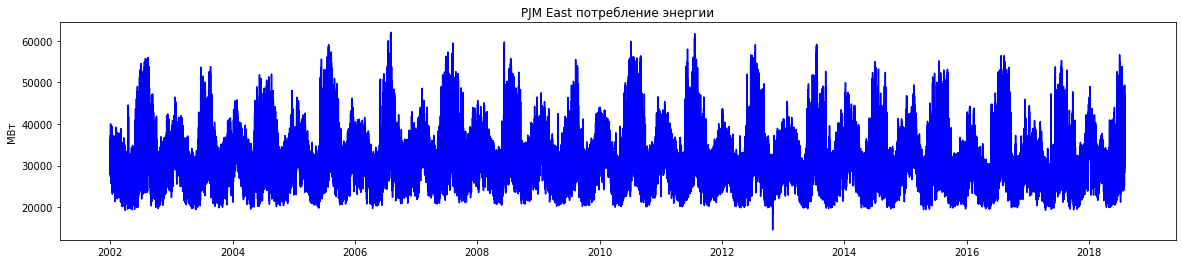

In [3]:
data['data_time']=data.index
plt.figure(figsize =(20,4))
plt.plot( data.index, data['PJME_MW'], 'b' )
plt.title('PJM East потребление энергии' )
plt.ylabel ( 'МВт' )
plt.show()

На графике выше мы можем наблюдать зимние и летние пики(включение отопления,обогревателей,кондеров и т.д.)

На графике ниже

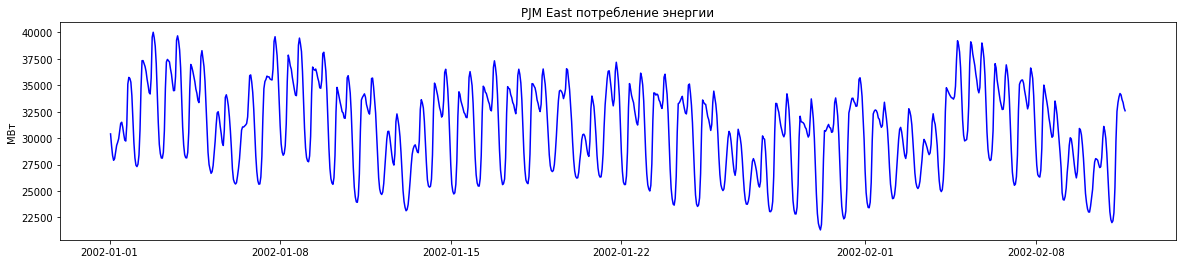

In [4]:
data['data_time']=data.index
plt.figure(figsize =(20,4))
plt.plot( data.index[:1000], data['PJME_MW'].iloc[:1000], 'b' )
plt.title('PJM East потребление энергии' )
plt.ylabel ( 'МВт' )
plt.show()

## Задача обнаружения аномалий ##

Для заданного множества объектов необходимо получить множество-исключение. 

С точки зрения временных рядов мы получаем следующее представление:
- Х - вектор наблюдения состоит из измерений временного ряда, а его длина соответствует ширине окна анализа.
- отклонение статистической характеристики вектора от остальных векторов можно считать аномалией. 


Основные задачи:
1.  Задача  распознавания  аномалий,  вытекающих  из  контекста  наблюдаемого  процесса.
2.  Задача  выделения  аномальных  участков  и  дифференциация  аномалий  от  шумов.
3.  Задача  распознавания  аномалий  путем  сравнения  идеальных  и  реальных  процессов.


**Типы аномалий**

Если анализировать только случайную компоненту, то многие аномалии можно свести к одному из следующих случаев:

***Выброс в данных временного ряда.*** Существенное амплитудное изменение ряда на коротком интервале. Классическая задача - работает правило трех сигм, межквартильный размах и другие.

***Изменение характера (распределения) значений.*** Движения временного ряда, связанные с редко происходящими событиями, имеющие скачкообразный характер и меняющие тенденцию. Эту часть предсказывать без внешней информации затруднительно.

***Отклонение от «повседневного» (для данных с циклом)*** Сравниваем текущий период и несколько предыдущих и оцениваем разницу. 

**Основные подходы к поиску аномалий**

- ***Метод  скользящего  окна***.  Ряд  разбивается  на  участки  (окна). Поиск  аномальной  подпоследовательности  осуществляется  при  помощи  скольжения  окна  по  всему  ряду  с  шагом  меньшим  длины  окна  ( размер  окна  нужно подобрать в эксперименте или задать на основе опыта,  увеличение  размера и числа окон  быстро повышают  вычислительную  сложность  алгоритма).  Метод  является  самым  универсальным,  и  применим  для  любых  типов рядов.


- ***Кластеризация***. Строит группировки измерений. Нет  представления  о  точности  границ  аномалий, пропускает  незначительные  аномалии. Универсальный  метод  поиска  аномалий.


- ***Статистические  методы***.  Используют  критерии  для  проверки  гипотез  о  сходстве  или  различии  двух  выборок.  Корреляционный  анализ между частями ряда может  служить  для  анализа  аномальности.  Хорошо работает в задачах  поиска  аномалий  в  физических  процессах. Анализ путём поиска представителей, которые меньше подходят к остальному набору данных.  

- ***Обнаружение аномалий основанное на модели регрессии временного ряда***. Наложив модель на данные, можно спрогнозировать тенденции, а затем проверить, все ли показатели соответствуют им. Для этого нужно сравнить спрогнозированные и фактические показатели. Значительная разница укажет на отклонение или аномалию.

 
- ***Выявления аномалий с учителем***. Требует предоставления данных, помеченных как «нормальные» и «ненормальные», и использует обучение классификатора (выборка очень несбалансирована). 


Посмотрим как применить различные техники поиска аномалий к нашему ряду. Разберем ряд на вектора и определим параметры распределения.

## Оценим поведение ряда

Посмотрим насколько среднее отличается вдоль каждого окна

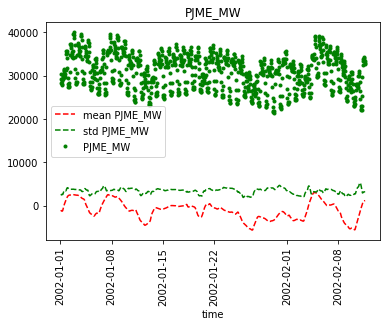

In [5]:
#размер окна  (в часах)
w = 24
#шаг окна  (в часах)
step_w= 1
mean_d=[]
std_d=[]

MeanT=np.mean(data['PJME_MW'])

for i in range(1000):
    d = data['PJME_MW'].iloc[i:i+w] - MeanT
    mean_d.append(np.mean(d))
    std_d.append(np.std(d))
plt.plot(data['data_time'].iloc[:1000],mean_d,'--r',label='mean PJME_MW')    
plt.plot(data['data_time'].iloc[:1000],std_d,'--g',label='std PJME_MW') 
plt.plot(data['data_time'].iloc[:1000],data['PJME_MW'].iloc[:1000],'.g',label='PJME_MW')
plt.title('PJME_MW')
plt.legend()
plt.xlabel('time')
plt.xticks(rotation='90')
plt.show()

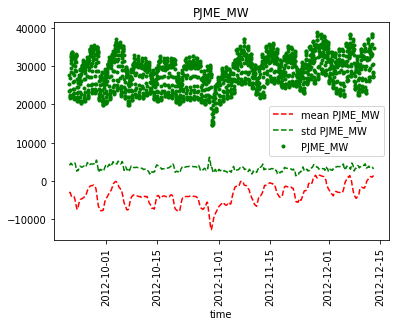

In [6]:
#размер окна  (в часах)
w = 24

#шаг окна  (в часах)
step_w= 1

T=24*365*11-24*100
mean_da=[]
std_da=[]
for i in range(2000):
    da = data['PJME_MW'].iloc[T+i:T+i+w] - MeanT
    mean_da.append(np.mean(da))
    std_da.append(np.std(da))
std_da = np.array(std_da)
plt.plot(data['data_time'].iloc[T:2000+T],mean_da,'--r',label='mean PJME_MW')    
plt.plot(data['data_time'].iloc[T:2000+T],std_da,'--g',label='std PJME_MW') 
plt.plot(data['data_time'].iloc[T:2000+T],data['PJME_MW'].iloc[T:2000+T],'.g',label='PJME_MW')
plt.title('PJME_MW')
plt.xlabel('time')
plt.legend()
plt.xticks(rotation='90')
plt.show()

На графике виден провал (ураган?). Кроме провала в основном ряду виден всплеск в ряду стандартных отклонений и провал в ряду средних. Можно построить простой тест: сглаживание - 1 день, D = |std_da[j]-mean[std_a]| > std_porog. Порог подберем по известной аномалии. В итоге получили метку для аномалии. Можем рассчитывать, что и другие аномалии найдем. Порог определен по разбросу стандартных отклонений ряда std_da (стандартное отклонение для стандартного отклонения), а коэффициент (80) результат подбора по известному факту аномалии.

Порог тут представлен как точка среднего, превышающего 3 сигма

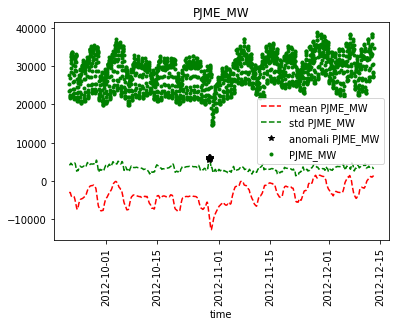

In [7]:
# порог - подобрали по известной аномалии
porog_ = np.abs(std_da - np.mean(std_da)) > (np.std(std_da)*3)
ind_ = np.where(porog_==1)[0]
plt.plot(data['data_time'].iloc[T:2000+T],mean_da,'--r',label='mean PJME_MW')    
plt.plot(data['data_time'].iloc[T:2000+T],std_da,'--g',label='std PJME_MW') 
plt.plot(data['data_time'].iloc[T:2000+T][ind_],std_da[ind_],'*k',label='anomali PJME_MW') 
plt.plot(data['data_time'].iloc[T:2000+T],data['PJME_MW'].iloc[T:2000+T],'.g',label='PJME_MW')
plt.title('PJME_MW')
plt.xlabel('time')
plt.legend()
plt.xticks(rotation='90')
plt.show()

Поиск аномалий подобным образом основан на прецедентах и может быть реализован как классификатор, если есть разметка.

## Первый подход.Скользящее окно

Очевидно, что средняя во времени может изменяться. Таким образом имеет смысл смотреть на сглаженные модели ряда  или на скользящие средние, которые позволяют моделировать основные тенденции ряда, его сезонность(цикличность) с тем, чтобы увидеть истинные статистические характеристики конкретного отрезка ряда. Сделаем сглаживание по среднему на дневные интервалы и месячные циклы сезона.

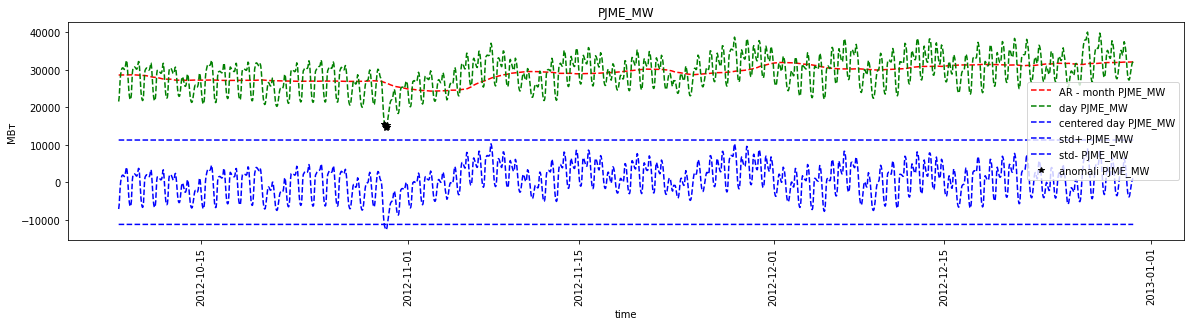

In [8]:
#размер окна  (в часах)
w = 24
#шаг окна  (в часах)
step_w= 1

data_m=data['PJME_MW'].rolling(w*30).mean() # роллинг вдоль скользящего окна(скользящее среднее на месячном окне)
diff_day = data['PJME_MW'].rolling(2).mean()#-data_m
data_d=data['PJME_MW'].rolling(w*7).mean()
#data_d[np.where(np.abs(data_d)<0.0001)[0]]=data_d.mean()
diff_day_month=diff_day-data_m
sigma3_diff_day_month = diff_day_month.std()*2

porog_ = np.abs(diff_day_month[-51000:-49000]) > sigma3_diff_day_month 
ind_ = np.where(porog_==1)[0]

plt.figure(figsize =(20,4))
plt.title('PJM East потребление энергии' )
plt.ylabel ( 'МВт' )
plt.plot(data['data_time'].iloc[-51000:-49000],data_d[-51000:-49000],'--r',label='AR - month PJME_MW')
plt.plot(data['data_time'].iloc[-51000:-49000],diff_day[-51000:-49000],'--g',label='day PJME_MW')
plt.plot(data['data_time'].iloc[-51000:-49000],diff_day_month[-51000:-49000],'--b',label='centered day PJME_MW')
plt.plot(data['data_time'].iloc[-51000:-49000],[-sigma3_diff_day_month]*2000 ,'--b',label='std+ PJME_MW')

plt.plot(data['data_time'].iloc[-51000:-49000],[sigma3_diff_day_month]*2000 ,'--b',label='std- PJME_MW')
plt.plot(data['data_time'].iloc[-51000:-49000].values[ind_],diff_day[-51000:-49000].values[ind_],'*k',label='anomali PJME_MW') 

plt.title('PJME_MW')
plt.xlabel('time')
plt.legend()
plt.xticks(rotation='90')
plt.show()

Скользящая статистика позволяет увидеть изменения характеристик статистики вдоль модели и отделять объекты, которые выпадают из статистики

## Второй подход. Кластеризация(кластер-анализ)

Собираем объекты, которые похожи друг на друга

**DBSCAN** может выделять "мусорные" объекты, тоесть те, которые не принадлежат ни одному из кластеров

In [9]:
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler

scl=StandardScaler()

from sklearn.cluster import KMeans, DBSCAN

In [10]:
data_d

2002-01-01 01:00:00             NaN
2002-01-01 02:00:00             NaN
2002-01-01 03:00:00             NaN
2002-01-01 04:00:00             NaN
2002-01-01 05:00:00             NaN
                           ...     
2018-08-02 20:00:00    35900.238095
2018-08-02 21:00:00    35892.583333
2018-08-02 22:00:00    35886.119048
2018-08-02 23:00:00    35881.500000
2018-08-03 00:00:00    35879.976190
Name: PJME_MW, Length: 145374, dtype: float64

In [11]:
data['stat' ] = diff_day 
p =3

#добавляем историю длиной р
for i in range(p):
    data['t'+str(p-i+1)]=0.0
    data['t'+str(p-i+1)].values[p+2:] = data['PJME_MW'].values[i+1:-(p-i+1)]
for i in range(p):
    data['d'+str(p-i+1)]=0.0    
    data['d'+str(p-i+1)].values[i+1:] = (data['PJME_MW'].values[i+1:]- data['PJME_MW'].values[i:-1])/data['PJME_MW'].values[i:-1]
data.head(10)

,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday,data_time,stat,t4,t3,t2,d4,d3,d2
2002-01-01 01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0,2002-01-01 01:00:00,NaN,0.0,0.0,0.0,0.000000,0.000000,0.000000
2002-01-01 02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0,2002-01-01 02:00:00,29829.0,0.0,0.0,0.0,-0.037114,0.000000,0.000000
2002-01-01 03:00:00,28357.0,2002,1,1,1,1,1,1,3,1,0,0,2002-01-01 03:00:00,28811.0,0.0,0.0,0.0,-0.031027,-0.031027,0.000000
2002-01-01 04:00:00,27899.0,2002,1,1,1,1,1,1,4,1,0,0,2002-01-01 04:00:00,28128.0,0.0,0.0,0.0,-0.016151,-0.016151,-0.016151
2002-01-01 05:00:00,28057.0,2002,1,1,1,1,1,1,5,1,0,0,2002-01-01 05:00:00,27978.0,0.0,0.0,0.0,0.005663,0.005663,0.005663
2002-01-01 06:00:00,28654.0,2002,1,1,1,1,1,1,6,1,0,0,2002-01-01 06:00:00,28355.5,29265.0,28357.0,27899.0,0.021278,0.021278,0.021278
2002-01-01 07:00:00,29308.0,2002,1,1,1,1,1,1,7,1,0,0,2002-01-01 07:00:00,28981.0,28357.0,27899.0,28057.0,0.022824,0.022824,0.022824
2002-01-01 08:00:00,29595.0,2002,1,1,1,1,1,1,8,1,0,0,2002-01-01 08:00:00,29451.5,27899.0,28057.0,28654.0,0.009793,0.009793,0.009793
2002-01-01 09:00:00,29943.0,2002,1,1,1,1,1,1,9,1,0,0,2002-01-01 09:00:00,29769.0,28057.0,28654.0,29308.0,0.011759,0.011759,0.011759
2002-01-01 10:00:00,30692.0,2002,1,1,1,1,1,1,10,1,0,0,2002-01-01 10:00:00,30317.5,28654.0,29308.0,29595.0,0.025014,0.025014,0.025014


In [12]:
X = data.drop(['data_time'],axis=1).iloc[p+2:,1:].values

Xscale = scl.fit_transform(X[-51000:-49000,:])

clast = DBSCAN(eps=2.0, leaf_size=5, min_samples = 5)
X_scale_clast =clast.fit_predict(Xscale)

первый элемент кластера 0  :  [ 0.         -1.34142074 -1.02932223  0.         -1.71979668 -1.59870342
 -1.50304942 -0.21615899  4.58017707 -0.19324699 -0.22454436  0.09032217
 -1.32233257 -0.6041549  -0.19498077  0.51514124  0.51514124  0.51514124]
Число кластеров с масштабированием:  17
Число не кластеров:  47


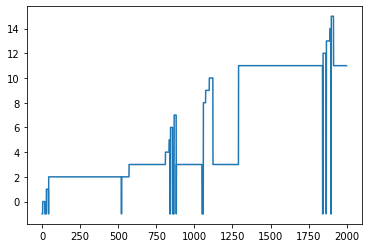

In [13]:
# не шум, но кластер со смыслом
ind_c= np.where(X_scale_clast !=-1)[0]
print('первый элемент кластера',X_scale_clast[ind_c[0]],' : ',clast.components_[0])
print('Число кластеров с масштабированием: ',len(np.unique(X_scale_clast)-1))

n_noise = list(clast.labels_).count(-1)

print('Число не кластеров: ',n_noise)

plt.plot(X_scale_clast)
plt.show()

Мы выделили 17 кластеров, и 47 примеров, которые не похожи на остальные

Следовательно - эти 47 образцов это кандидаты на аномалии, которые нужно разбирать.

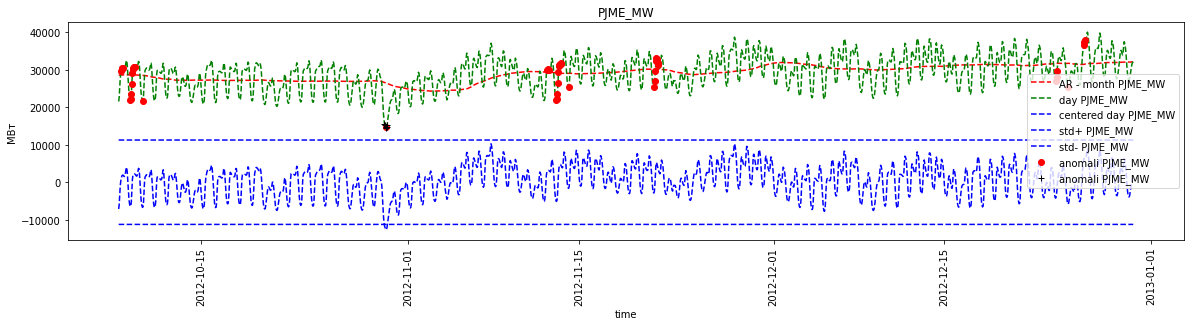

In [14]:
ind_anomal_c= np.where(X_scale_clast ==-1)[0]  # индексы аномалий (наверное аномалий - будем смотреть)

ind_anomal_c = np.array(ind_anomal_c)+p+2  


plt.figure(figsize =(20,4))
plt.title('PJM East потребление энергии' )
plt.ylabel ( 'МВт' )
plt.plot(data['data_time'].iloc[-51000:-49000],data_d[-51000:-49000],'--r',label='AR - month PJME_MW')
plt.plot(data['data_time'].iloc[-51000:-49000],diff_day[-51000:-49000],'--g',label='day PJME_MW')
plt.plot(data['data_time'].iloc[-51000:-49000],diff_day_month[-51000:-49000],'--b',label='centered day PJME_MW')
plt.plot(data['data_time'].iloc[-51000:-49000],[-sigma3_diff_day_month]*2000 ,'--b',label='std+ PJME_MW')

plt.plot(data['data_time'].iloc[-51000:-49000],[sigma3_diff_day_month]*2000 ,'--b',label='std- PJME_MW')
plt.plot(data['data_time'].iloc[-51000:-49000].values[ind_anomal_c],diff_day[-51000:-49000].values[ind_anomal_c],'or',label='anomali PJME_MW') 
plt.plot(data['data_time'].iloc[-51000:-49000].values[ind_],diff_day[-51000:-49000].values[ind_],'+k',label='anomali PJME_MW') 

plt.title('PJME_MW')
plt.xlabel('time')
plt.legend()
plt.xticks(rotation='90')
plt.show()

Добавили анализ по кластерам к анализу по статистике скользящих окон и видим совпадение точки для 30.10.2012. Можно расчитывать на то, что это аномалия. Однако проверим еще раз используя модель ряда.

In [15]:
data_week=data['PJME_MW'].resample("W").apply('mean') # .resample("W") - недельный ресемплинг

np.where(data_week.index.weekofyear == pd.to_datetime('2012-10-30').weekofyear)[0]

array([ 43,  95, 147, 200, 252, 304, 356, 408, 461, 513, 565, 617, 669,
       721, 774, 826], dtype=int64)

Сделаем ресемплинг, для ускорения работы модели на недельные отсчеты. Построим модель ряда по ARIMA (опираясь на результаты урока 2)

**SARIMAX** - одна из классических эконометрических форм анализа временных рядов

Техника представления авторегрессионных интегрируемых скользящих средний

In [16]:
import statsmodels.api as sm
mod = sm.tsa.statespace.SARIMAX(data_week.values[200:560],order=[0,0,0],
                                seasonal_order=[2,0,0,52] ,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results_opt = mod.fit()
print('AIC:{}',results_opt.aic)
# AIC - информационный критерий для оценки

AIC:{} 4722.690984524124


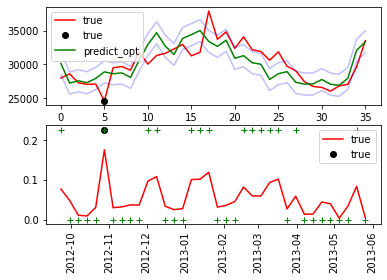

In [17]:
data_month = data_week.copy()  

pred_dynamic_opt = results_opt.forecast(12*3)
predict_ = results_opt.get_prediction(end=results_opt.nobs + 12*3)
predict_ci = predict_.conf_int(alpha=0.5)


plt.subplot(2,1,1)
plt.plot( data_month.values[560:560+12*3], 'r',label='true' )
plt.plot( 5,data_month.values[565], 'ok',label='true' )
plt.plot(pred_dynamic_opt,'g', label='predict_opt' )
plt.plot( predict_ci[results_opt.nobs:results_opt.nobs+12*3, 0], 'b',alpha=0.25)
plt.plot( predict_ci[results_opt.nobs:results_opt.nobs+12*3, 1], 'b',alpha=0.25)
plt.legend()
condition_anomal = (data_month.values[560:560+12*3] < predict_ci[results_opt.nobs:results_opt.nobs+12*3, 0]) | (data_month.values[560:560+12*3] > predict_ci[results_opt.nobs:results_opt.nobs+12*3, 1])
ind_anomal = np.where(condition_anomal == True)[0]
anomal_scl = np.abs(data_month.values[565]-pred_dynamic_opt[0])/data_month.values[565]

plt.subplot(2,1,2)
plt.plot( data_month.index[560-1:560+12*3-1],np.abs(data_month.values[560:560+12*3]-pred_dynamic_opt)/data_month.values[560:560+12*3], 'r',label='true' )
plt.plot( data_month.index[565-1],anomal_scl, 'ok',label='true' )
plt.plot(data_month.index[560-1:560+12*3-1],condition_anomal.astype(int) * anomal_scl,'+g')
plt.xticks(rotation='90')
plt.legend()
plt.show()

Смотрим на то, что было реально(первый рисунок)

Мы видим, что предикт поведения ряда сильно отличается от нашего реального наблюдения.

Разница предикта и наблюдаемого результат на каждом скользящем окне может стать основанием для выявления аномалии

Видно, что аномалия 2012.10.30 лежит на уровне больших ошибок. Это позволяет ее с хорошей вероятностью считать аномалией поведения ряда (на других участках ряда эта модель дает примерно одинаковые ошибки, а тут видим значительное возрастание ошибки на отрезке до 1 месяца). Таким образом подтверждена проблема ряда 30.10.2012.

Замечание: Визуальный анализ и анализ уровней выявляет аномалию амплитуды, однако не выявит аномалии частотного типа. Для этого следует перейти не к статистикам ряда, а к методам частотного анализа (спектральным моделям анализа ряда, например).

**КАК ИСПОЛЬЗОВАТЬ АНОМАЛИИ:**
 - Построить набор примеров для классификации следующих аномалий.
 - Проверить модель на следующих интервалах, вдруг это не аномалия.

In [18]:
data.drop(['data_time'],axis=1,inplace=True)

In [19]:
data.iloc[100:105,:]

,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday,stat,t4,t3,t2,d4,d3,d2
2002-01-05 05:00:00,26822.0,2002,1,5,1,5,1,5,5,0,0,0,26745.5,28635.0,27501.0,27034.0,0.005737,0.005737,0.005737
2002-01-05 06:00:00,27399.0,2002,1,5,1,5,1,5,6,0,0,0,27110.5,27501.0,27034.0,26669.0,0.021512,0.021512,0.021512
2002-01-05 07:00:00,28557.0,2002,1,5,1,5,1,5,7,0,0,0,27978.0,27034.0,26669.0,26822.0,0.042264,0.042264,0.042264
2002-01-05 08:00:00,29709.0,2002,1,5,1,5,1,5,8,0,0,0,29133.0,26669.0,26822.0,27399.0,0.040340,0.040340,0.040340
2002-01-05 09:00:00,31241.0,2002,1,5,1,5,1,5,9,0,0,0,30475.0,26822.0,27399.0,28557.0,0.051567,0.051567,0.051567


In [20]:
data = data.iloc[-48000:,:]

## Выделение существенных признаков

Запишем итоговую систему признаков и проведем ее анализ. Горизонт прогнозирования h = 1, тогда target = y(t+h)=y(t+1) 

In [21]:
scl_target=StandardScaler() 

h=1
target = data["PJME_MW"].values[h:].reshape((data.shape[0]-h,1))
y = scl_target.fit_transform(target)
y.shape

(47999, 1)

In [22]:
scl_x=StandardScaler() 

X = data.iloc[:-h,:].values
X = scl_x.fit_transform(X.astype('float64'))
X.shape

(47999, 19)

Размеры выборок по строкам совпали. Мы взяли на h строк меньше для Х и на h значений позднее по target. Таким образом, входной набор данных сформирован.

Получаем список наиболее важный признаков по меркам f-теста

In [23]:
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.feature_selection import SelectFromModel

from sklearn.ensemble import GradientBoostingRegressor

from sklearn.feature_selection import f_regression, mutual_info_regression

f_test, _ = f_regression(X, y.ravel())

for i in range(X.shape[1]):
    print("F-test={:.2f},  I={}".format(f_test[i],i))

F-test=997575.69,  I=0
F-test=16.01,  I=1
F-test=321.20,  I=2
F-test=5.11,  I=3
F-test=336.18,  I=4
F-test=321.65,  I=5
F-test=334.21,  I=6
F-test=1552.55,  I=7
F-test=9734.87,  I=8
F-test=5.35,  I=9
F-test=22.34,  I=10
F-test=46.85,  I=11
F-test=454894.95,  I=12
F-test=28723.40,  I=13
F-test=51982.60,  I=14
F-test=102504.12,  I=15
F-test=4128.94,  I=16
F-test=4128.94,  I=17
F-test=4128.94,  I=18


Проверка через F-test показывает, что есть корреляционная связь с предшествующим значением ряда (признак X[:,0]), а кроме этого интересные признаки 0 , 12,13, 18, .. . Применим автоматизацию выбора через SelectKBest c выделением 5 лучших признаков.

In [24]:
sfk =SelectKBest(f_regression, k=5)
X_new1 =sfk.fit_transform(X, y.ravel())
X_new1.shape

(47999, 5)

Лучшее множество признаков отделенов X_new1. Проверим результат оценки признаков по процентному отбору и сохраним его в X_new2.

In [25]:
sfp=SelectPercentile(f_regression, percentile=10)
X_new2 = sfp.fit_transform(X, y.ravel())
X_new2.shape

(47999, 2)

Наконец, третий вариант - применим выделение признаков через построение модели . Помним , что модель должна уметь выбрать подмножество признаков или вернуть коэффициент их влиятельности. Это ограничивает выбор моделей. Возьмем как оценшик GradientBoostingRegressor и построим новое пространство в X_new3

In [26]:
gr_model = GradientBoostingRegressor(max_depth=5, random_state=40, n_estimators=100).fit(X, y.ravel())
sfm = SelectFromModel(gr_model,  max_features = 5)

sfm.fit(X, y.ravel())
X_new3 = sfm.transform(X)
X_new3.shape

(47999, 1)

Сравним результаты:

In [27]:
[X_new1[:5,:], X_new2[:5,:],X_new3[:5,:]]

[array([[ 0.05017909, -0.01665165, -0.12720777, -0.16030883, -0.15689809],
        [ 0.24869416,  0.15032529, -0.16027134, -0.15686158, -0.08325505],
        [ 0.3865736 ,  0.31950862, -0.15682395, -0.0832159 ,  0.05024255],
        [ 0.45958703,  0.42557325, -0.08317525,  0.05028648,  0.24876539],
        [ 0.42292364,  0.44385483,  0.0503326 ,  0.24881644,  0.38665023]]),
 array([[ 0.05017909, -0.01665165],
        [ 0.24869416,  0.15032529],
        [ 0.3865736 ,  0.31950862],
        [ 0.45958703,  0.42557325],
        [ 0.42292364,  0.44385483]]),
 array([[0.05017909],
        [0.24869416],
        [0.3865736 ],
        [0.45958703],
        [0.42292364]])]

In [28]:
list_param_k =np.where(sfk.get_support())[0]
list_param_p =np.where(sfp.get_support())[0]
list_param_m =np.where(sfm.get_support())[0]

print('Номера признаков k лучших признаков : ',list_param_k)
print('Номера признаков лучших признаков по процентной форме: ',list_param_p)
print('Номера признаков для выбора по модели : ',list_param_m)

Номера признаков k лучших признаков :  [ 0 12 13 14 15]
Номера признаков лучших признаков по процентной форме:  [ 0 12]
Номера признаков для выбора по модели :  [0]


Пересечение выбора по отбору для модели и по количественным оценкам связи в признаке 0. Имеет смысл брать объединение выборов. Возьмем [0,6,14,21] признаки и перейдем к построению модели.

In [29]:
X_new = X[:,[0,14,12,13,15]]

## Разделение данных на тестовые и тренировочные 

Построение модели начинаем с выделения тестовой части нашего ряда. Напомним, что для временных рядов тест - непрерывная часть ряда не входившая в обучение (временные ряды 1). Будем отделять по индексу, который задаст дату разделения модели на тест и обучение.

In [30]:
# сделаем функцию
def split_data( data, split_date ):
    return data.iloc[:split_date,:].copy(), \
           data.iloc[split_date:,:].copy()

Для временного ряда "Потребление энергии" назначим датой разделения 100 от конца

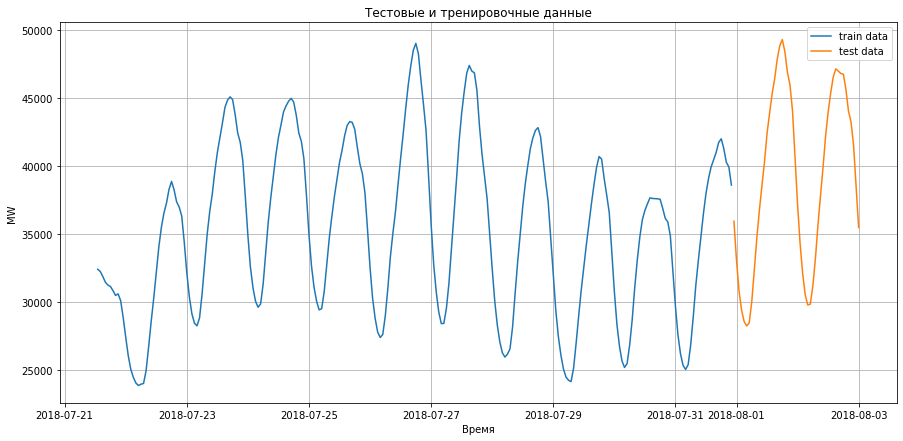

In [31]:
N_x = -300
N_split = -50

train, test = split_data( data[N_x:], N_split)

plt.figure( figsize=( 15, 7 ))
plt.xlabel('Время')
plt.ylabel('MW')
plt.plot(train.index,train.iloc[:,0], label='train data' )
plt.plot(test.index,test.iloc[:,0], label='test data')
plt.title( 'Тестовые и тренировочные данные' )
plt.grid()
plt.legend()
plt.show()

In [32]:
X_train =X_new[N_x:N_split,:]
y_train =y[N_x:N_split,0]
X_test =X_new[N_split:,:]
y_test =y[N_split:,0]

In [33]:
train.shape

(250, 19)

# Строим Модель

При решении задачи на начальном этапе, самый интересный результат был получен на модели GradientBoostingRegressor. Остановимся на построении иенно такой формы предсказания. Импортируем необходимые модели.

In [34]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression

Все модели возьмем в варианте параметров по умолчанию.

In [35]:
model_g = GradientBoostingRegressor(max_depth=5, random_state=10, n_estimators=1000)
model_l = LinearRegression()

In [36]:
model_l.fit( X_train, y_train ) 
model_g.fit( X_train, y_train ) 

GradientBoostingRegressor(max_depth=5, n_estimators=1000, random_state=10)

**Посмотрим тесты**

In [37]:
y_pred_g = model_g.predict(X_train)
y_pred_l= model_l.predict(X_train)

y_test_pred_g = model_g.predict(X_test)
y_test_pred_l= model_l.predict(X_test)

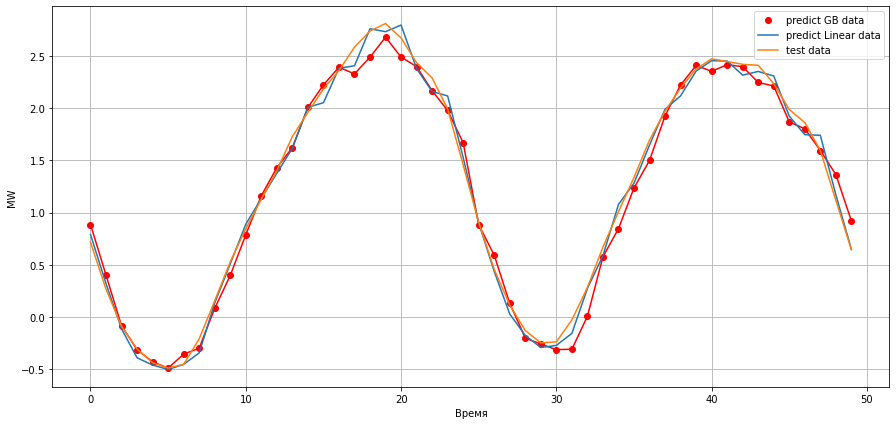

In [38]:
plt.figure( figsize=( 15, 7 ))


plt.xlabel('Время')
plt.ylabel('MW')
plt.plot(y_test_pred_g[:100],'or', label='predict GB data' )
plt.plot(y_test_pred_g[:100],'r' )
plt.plot(y_test_pred_l[:100], label='predict Linear data' )
plt.plot(y_test[:100], label='test data')
plt.grid()
plt.legend()
plt.show()

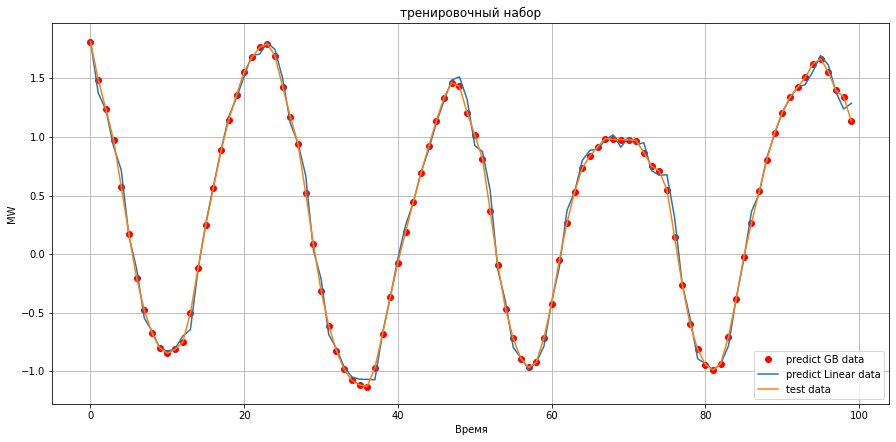

In [39]:
plt.figure( figsize=( 15, 7 ))

plt.title('тренировочный набор')
plt.xlabel('Время')
plt.ylabel('MW')
plt.plot(y_pred_g[-100:],'or', label='predict GB data' )
plt.plot(y_pred_l[-100:], label='predict Linear data' )
plt.plot(y_train[-100:], label='test data')
plt.grid()
plt.legend()
plt.show()

Линейная модель практически не работает, т.к. видно запаздывание в размере h.Градиентный бустинг практически не отличается от нее на интервале обучения. Посмотрим на оценки.

**Оценки для сравнения моделей**

In [40]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

In [41]:
er_s = mean_squared_error(y_true=y_test, y_pred=y_test_pred_g) 
er_a = mean_absolute_error(y_true=y_test, y_pred=y_test_pred_g) 
er_r2 = r2_score(y_true=y_test, y_pred=y_test_pred_g)

print('ошибка mse :  ', er_s,'\nошибка mae  :  ', er_a,'\nоценка R2 :  ', er_r2)

ошибка mse :   0.016376127133361437 
ошибка mae  :   0.09739916425689568 
оценка R2 :   0.9850964464980833


Абсолютная процентная ошибка (MAPE).Обратите внимание, что определять ее для масштабированной переменной не верно. Поэтому переведем ответ решателя обратно в состояние без масштаба.

In [42]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [43]:
er_g = mean_absolute_percentage_error(y_true=scl_target.inverse_transform( y_test),y_pred = scl_target.inverse_transform( y_test_pred_g))

print('ошибка градиентного бустинга MAPE :  ', er_g,'%')

ошибка градиентного бустинга MAPE :   1.6075287065915747 %


In [44]:
from sklearn.model_selection import RandomizedSearchCV

def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

param_dist = {"max_depth": [3, 2,1,4,5], 
              "n_estimators":[100,200,300,400,500]}

#  randomized search
n_iter_search = 10

model_gr =GradientBoostingRegressor()

random_search = RandomizedSearchCV(model_gr, param_distributions=param_dist, n_iter=n_iter_search, cv=5, iid=False)

random_search.fit(X_train, y_train)

report(random_search.cv_results_)

Model with rank: 1
Mean validation score: 0.963 (std: 0.018)
Parameters: {'n_estimators': 500, 'max_depth': 3}

Model with rank: 2
Mean validation score: 0.963 (std: 0.018)
Parameters: {'n_estimators': 100, 'max_depth': 3}

Model with rank: 3
Mean validation score: 0.962 (std: 0.018)
Parameters: {'n_estimators': 300, 'max_depth': 2}



In [46]:
model_g_best = GradientBoostingRegressor(max_depth=3,  n_estimators=100)
model_g_best.fit( X_train, y_train ) 
y_test_pred_g = model_g_best.predict(X_test)

er_g = mean_absolute_percentage_error(y_true=scl_target.inverse_transform( y_test),y_pred = scl_target.inverse_transform( y_test_pred_g))
print('ошибка градиентного бустинга MAPE :  ', er_g,'%')

ошибка градиентного бустинга MAPE :   1.7216013397690897 %


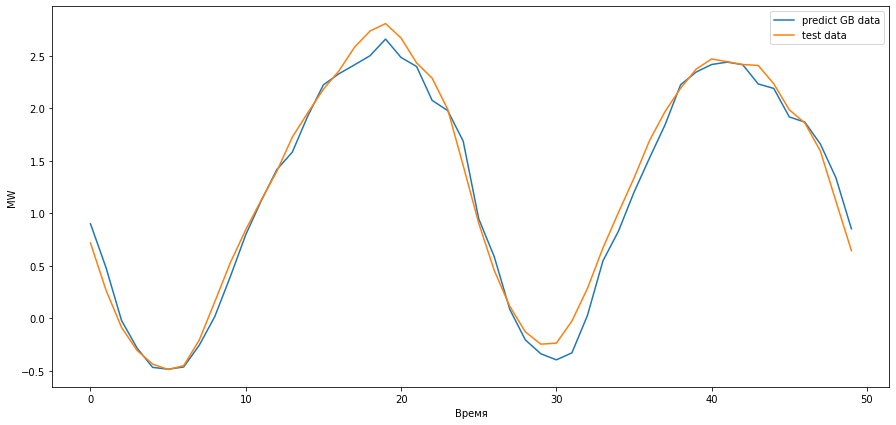

In [47]:
plt.figure( figsize=( 15, 7 ))


plt.xlabel('Время')
plt.ylabel('MW')
plt.plot(y_test_pred_g, label='predict GB data' )
plt.plot(y_test, label='test data')

plt.legend()
plt.show()

Оценим качетво результата за счет лаговой корреляции(кривой корреляции)

Сдвиги теста относительно предсказания

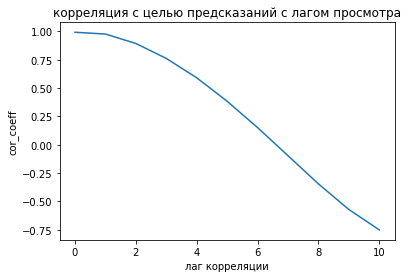

In [48]:
lag=10
p_cor=[np.corrcoef( y_test, y_test_pred_g)[1,0]]
for i in range(lag):
    c=np.corrcoef( y_test[:-(i+1)], y_test_pred_g[(i+1):])[1,0]
    p_cor.append(c)    

plt.plot(np.array(p_cor) )  
plt.xlabel('лаг корреляции')
plt.ylabel('cor_coeff')
plt.title('корреляция с целью предсказаний с лагом просмотра')
plt.show()

## Сохраниение модели

In [49]:
import pickle
# save the model to disk
filename = 'final_model.sav'
pickle.dump(model_g_best, open(filename, 'wb'))

filename = 'final_scaler_y.sav'
pickle.dump(scl_target, open(filename, 'wb'))

filename = 'final_scaler_x.sav'
pickle.dump(scl_x, open(filename, 'wb'))

## Заключение

Прогнозирование на основе обучения позволяет эффективно описывать достаточно сложные данные. Построение прогноза на основе генерации регрессионных моделей позволит построить хороший ответ даже не зная как устроен ряд и каковы его статистические свойства. При решении задачи прогнозирования следует учитывать следующие особенности этого подхода:
- Строим много признаков.
- Обрабатываем признаки и используем результаты статистического анализа ряда для придумывания новых признаков.
- Строим много моделей и не забываем, что тестирование моделей идет только на последних точках ряда.
- Используем правильные метрики.
- Следим за аномалиями